https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_clipping.py

https://medium.com/coinmonks/celebrity-face-generation-using-gans-tensorflow-implementation-eaa2001eef86

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import time as t
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import os
from torchvision import utils
# from utils.tensorboard_logger import Logger
import torchvision.transforms as transforms
import torchvision.datasets as dset
from PIL import Image

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

In [3]:
device

device(type='cuda')

In [4]:
import tensorflow as tf
import numpy as np
import scipy.misc
from io import BytesIO


class Logger(object):

    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
#             scipy.misc.toimage(img).save(s, format="png")
            Image.fromarray((img * 255).astype(np.uint8)).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [5]:
class Generator(torch.nn.Module):

    def __init__(self, channels):
        def conv_mob(inp, oup):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, 1, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.LeakyReLU(0.2,inplace=True),

                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.LeakyReLU(0.2,inplace=True),
            )
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            
#             # State (512x8x8)
#             nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(num_features=256),
#             nn.ReLU(True),
            
#             # State (256x16x16)
#             conv_mob(256, 256),
#             nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=3, stride=1, padding=1))
#             # output of main module --> Image (Cx32x32)
            
            # State (256x16x16)
            conv_mob(256, 256),
            nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=4, stride=2, padding=1))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0))


    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*4*4)



In [6]:
class WGAN_CP(object):
    def __init__(self, channels = 3, cuda = True, generator_iters = 30000):
        print("WGAN_CP init model.")
        self.G = Generator(channels)
        self.D = Discriminator(channels)
        self.C = channels

        # check if cuda is available
        self.check_cuda(cuda)

        # WGAN values from paper
        self.learning_rate = 0.00005

        self.batch_size = 64
        self.weight_cliping_limit = 0.01

        # WGAN with gradient clipping uses RMSprop instead of ADAM
        self.d_optimizer = torch.optim.RMSprop(self.D.parameters(), lr=self.learning_rate)
        self.g_optimizer = torch.optim.RMSprop(self.G.parameters(), lr=self.learning_rate)

#         # Set the logger
#         self.logger = Logger('./logs')
#         self.logger.writer.flush()
        self.number_of_images = 10

        self.generator_iters = generator_iters
        self.critic_iter = 5


    def check_cuda(self, cuda_flag=False):
        if cuda_flag:
            self.cuda_index = 0
            self.cuda = True
            self.D.cuda()
            self.G.cuda()
            print("Cuda enabled flag: {}".format(self.cuda))


    def train(self, train_loader):
        self.t_begin = t.time()
        #self.file = open("inception_score_graph.txt", "w")

        # Now batches are callable self.data.next()
        self.data = self.get_infinite_batches(train_loader)

        one = torch.FloatTensor([1])
        mone = one * -1
        if self.cuda:
            one = one.cuda()
            mone = mone.cuda()
            
        print('------ TRAINING BEGINS -------') ########################################

        for g_iter in range(self.generator_iters):
#             print('------ IN BEGINNING G_ITER -------') ########################################
            # Requires grad, Generator requires_grad = False
            for p in self.D.parameters():
                p.requires_grad = True
#                 print('------ IN REQUIRES GRAD -------') ########################################


            # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
            for d_iter in range(self.critic_iter):
                self.D.zero_grad()
#                 print('------ IN DISCRIMINATOR FORWARD TRAIN ---------') ########################################


                # Clamp parameters to a range [-c, c], c=self.weight_cliping_limit
                for p in self.D.parameters():
                    p.data.clamp_(-self.weight_cliping_limit, self.weight_cliping_limit)
#                     print('------ IN WEIGHT CLIPPING -------') ########################################

                images = self.data.__next__()
                # Check for batch to have full batch_size
                if (images.size()[0] != self.batch_size):
                    continue

                z = torch.rand((self.batch_size, 100, 1, 1))

                if self.cuda:
                    images, z = Variable(images.cuda()), Variable(z.cuda())
                else:
                    images, z = Variable(images), Variable(z)


                # Train discriminator
                # WGAN - Training discriminator more iterations than generator
                # Train with real images
                d_loss_real = self.D(images)
                d_loss_real = d_loss_real.mean(0).view(1)
                d_loss_real.backward(one)

                # Train with fake images
                if self.cuda:
                    z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
                else:
                    z = Variable(torch.randn(self.batch_size, 100, 1, 1))
                fake_images = self.G(z)
#                 print('fake_images:', fake_images.shape)
#                 print('==============================')
                d_loss_fake = self.D(fake_images)
#                 print("d_loss_fake", d_loss_fake.shape)
#                 print('=================')
#                 print('mean', d_loss_fake.mean(0))
                d_loss_fake = d_loss_fake.mean(0).view(1)
                d_loss_fake.backward(mone)

                d_loss = d_loss_fake - d_loss_real
                Wasserstein_D = d_loss_real - d_loss_fake
                self.d_optimizer.step()


            # Generator update
            for p in self.D.parameters():
                p.requires_grad = False  # to avoid computation
#                 print('-------- IN GENERATOR UPDATE --------') #####################################################3

            self.G.zero_grad()

            # Train generator
            # Compute loss with fake images
            z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
            fake_images = self.G(z)
            g_loss = self.D(fake_images)
            g_loss = g_loss.mean().mean(0).view(1)
            g_loss.backward(one)
            g_cost = -g_loss
            self.g_optimizer.step()

            # Saving model and sampling images every 1000th generator iterations
            if (g_iter) % 1000 == 0:
                self.save_model()
                # Workaround because graphic card memory can't store more than 830 examples in memory for generating image
                # Therefore doing loop and generating 800 examples and stacking into list of samples to get 8000 generated images
                # This way Inception score is more correct since there are different generated examples from every class of Inception model
                # sample_list = []
                # for i in range(10):
                #     z = Variable(torch.randn(800, 100, 1, 1)).cuda(self.cuda_index)
                #     samples = self.G(z)
                #     sample_list.append(samples.data.cpu().numpy())
                #
                # # Flattening list of list into one list
                # new_sample_list = list(chain.from_iterable(sample_list))
                # print("Calculating Inception Score over 8k generated images")
                # # Feeding list of numpy arrays
                # inception_score = get_inception_score(new_sample_list, cuda=True, batch_size=32,
                #                                       resize=True, splits=10)

                if not os.path.exists('training_result_images/'):
                    os.makedirs('training_result_images/')

                # Denormalize images and save them in grid 8x8
                z = Variable(torch.randn(800, 100, 1, 1)).cuda(self.cuda_index)
                samples = self.G(z)
                samples = samples.mul(0.5).add(0.5)
                samples = samples.data.cpu()[:64]
                grid = utils.make_grid(samples)
                utils.save_image(grid, 'training_result_images/img_generatori_iter_{}.png'.format(str(g_iter).zfill(3)))

                # Testing
                time = t.time() - self.t_begin
                #print("Inception score: {}".format(inception_score))
                print("Generator iter: {}".format(g_iter))
                print("Time {}".format(time))

                # Write to file inception_score, gen_iters, time
                #output = str(g_iter) + " " + str(time) + " " + str(inception_score[0]) + "\n"
                #self.file.write(output)


                # ============ TensorBoard logging ============#
                # (1) Log the scalar values
                info = {
                    'Wasserstein distance': Wasserstein_D.data[0],
                    'Loss D': d_loss.data[0],
                    'Loss G': g_cost.data[0],
                    'Loss D Real': d_loss_real.data[0],
                    'Loss D Fake': d_loss_fake.data[0]

                }

#                 for tag, value in info.items():
#                     self.logger.scalar_summary(tag, value, g_iter + 1)
#                     print('in logger. hi') ###############################################

#                 # (3) Log the images
#                 info = {
#                     'real_images': self.real_images(images, self.number_of_images),
#                     'generated_images': self.generate_img(z, self.number_of_images)
#                 }

#                 for tag, images in info.items():
#                     self.logger.image_summary(tag, images, g_iter + 1)
#                     print('in logger. hi22222')###################


        self.t_end = t.time()
        print('Time of training-{}'.format((self.t_end - self.t_begin)))
        #self.file.close()

        # Save the trained parameters
        self.save_model()

    def evaluate(self, test_loader, D_model_path, G_model_path):
        self.load_model(D_model_path, G_model_path)
        z = Variable(torch.randn(self.batch_size, 100, 1, 1)).cuda()
        samples = self.G(z)
        samples = samples.mul(0.5).add(0.5)
        samples = samples.data.cpu()
        grid = utils.make_grid(samples)
        print("Grid of 8x8 images saved to 'dgan_model_image.png'.")
        utils.save_image(grid, 'dgan_model_image.png')

    def real_images(self, images, number_of_images):
        if (self.C == 3):
            return self.to_np(images.view(-1, self.C, 32, 32)[:self.number_of_images])
        else:
            return self.to_np(images.view(-1, 32, 32)[:self.number_of_images])

    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu().numpy()[:number_of_images]
        generated_images = []
        for sample in samples:
            if self.C == 3:
                generated_images.append(sample.reshape(self.C, 32, 32))
            else:
                generated_images.append(sample.reshape(32, 32))
        return generated_images

    def to_np(self, x):
        return x.data.cpu().numpy()

    def save_model(self):
        torch.save(self.G.state_dict(), './generator.pkl')
        torch.save(self.D.state_dict(), './discriminator.pkl')
        print('Models save to ./generator.pkl & ./discriminator.pkl ')

    def load_model(self, D_model_filename, G_model_filename):
        D_model_path = os.path.join(os.getcwd(), D_model_filename)
        G_model_path = os.path.join(os.getcwd(), G_model_filename)
        self.D.load_state_dict(torch.load(D_model_path))
        self.G.load_state_dict(torch.load(G_model_path))
        print('Generator model loaded from {}.'.format(G_model_path))
        print('Discriminator model loaded from {}-'.format(D_model_path))

    def get_infinite_batches(self, data_loader):
        while True:
            for i, (images, _) in enumerate(data_loader):
                yield images


    def generate_latent_walk(self, number):
        if not os.path.exists('interpolated_images/'):
            os.makedirs('interpolated_images/')

        number_int = 10
        # interpolate between twe noise(z1, z2).
        z_intp = torch.FloatTensor(1, 100, 1, 1)
        z1 = torch.randn(1, 100, 1, 1)
        z2 = torch.randn(1, 100, 1, 1)
        if self.cuda:
            z_intp = z_intp.cuda()
            z1 = z1.cuda()
            z2 = z2.cuda()

        z_intp = Variable(z_intp)
        images = []
        alpha = 1.0 / float(number_int + 1)
        print(alpha)
        for i in range(1, number_int + 1):
            z_intp.data = z1*alpha + z2*(1.0 - alpha)
            alpha += alpha
            fake_im = self.G(z_intp)
            fake_im = fake_im.mul(0.5).add(0.5) #denormalize
            images.append(fake_im.view(self.C,32,32).data.cpu())

        grid = utils.make_grid(images, nrow=number_int )
        utils.save_image(grid, 'interpolated_images/interpolated_{}.png'.format(str(number).zfill(3)))
        print("Saved interpolated images.")

In [7]:
# # dataroot = '/home/aiden/Downloads/celeba'
dataroot = (r"C:\Users\Artificial Intellige\Desktop\celeba")
crop_size =32
re_size = 64
pad_size=(0,0,0,18) #for centering the image
# trans = transforms.Compose([
#             transforms.Scale(32),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         ])
# face_width = face_height = 108
image_size = 32
# j = (image_size - face_width) // 2
# i = (image_size - face_height) // 2
trans = transforms.Compose([
           transforms.Resize(re_size),
           transforms.Pad(pad_size),
           transforms.CenterCrop(crop_size),
           transforms.ToTensor(),
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
       ])


dataset = dset.ImageFolder(root=dataroot,
                           transform=trans)

dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,
                                       shuffle=True, num_workers=2)
# train_dataset = dset.CIFAR10(root=dataroot, train=True, download=False, transform=trans)
# test_dataset = dset.CIFAR10(root=dataroot, train=False, download=False, transform=trans)

# train_dataloader = data_utils.DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataloader  = data_utils.DataLoader(test_dataset,  batch_size=64, shuffle=True)

In [8]:
# dataroot = (r"C:\Users\Artificial Intellige\Desktop\Untitled Folder\Untitled Folder\dataset\DATA")


# trans = transforms.Compose([
#             transforms.Scale(32),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,), (0.5,)),
#         ])
# train_dataset = dset.MNIST(root=dataroot, train=True, download=False, transform=trans)
# test_dataset = dset.MNIST(root=dataroot, train=False, download=False, transform=trans)

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 0)
# test_dataloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=64, shuffle=True, num_workers = 0)

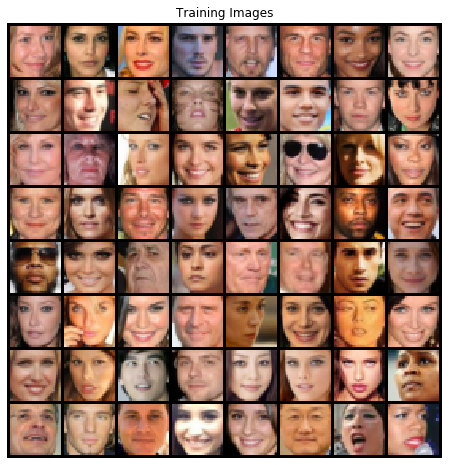

In [9]:
import numpy as np
import torchvision.utils as vutils

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
model = WGAN_CP()

model.train(dataloader)

WGAN_CP init model.
Cuda enabled flag: True
------ TRAINING BEGINS -------
Models save to ./generator.pkl & ./discriminator.pkl 
Generator iter: 0
Time 4.934247732162476


KeyboardInterrupt: 

In [ ]:
# started running at 2:40pm. the text for making sure i dont have a inf loop. so far so good but might take a while.
# delete comments if training is happening. can check its training by ctrl+f 'generator iter:'
# at 11:31 got 9 search result for generator iter

# model = WGAN_CP()
# model.evaluate(dataloader, r"C:\Users\Artificial Intellige\Downloads\discriminator.pkl", r"C:\Users\Artificial Intellige\Downloads\generator.pkl")
# for i in range(50):
#     model.generate_latent_walk(i)

In [11]:
# torch.cuda.empty_cache()